In [6]:
using ProfileView

In [7]:
using ForwardDiff

In [8]:
using Flatten

In [1]:
# workspace()
using FixedSizeArrays

immutable PendulumPosition{T} <: FixedVectorNoTuple{1, T}
    theta::T
end

immutable PendulumVelocity{T} <: FixedVectorNoTuple{1, T}
    theta::T
end

immutable PendulumState{T} <: FixedVectorNoTuple{2, T}
    position::PendulumPosition{T}
    velocity::PendulumVelocity{T}
end

immutable PendulumInput{T} <: FixedVectorNoTuple{1, T}
    theta::T
end

type Pendulum{T}
    length::T
    mass::T
    damping::T
    gravity::T
end

import Base: convert
convert{T}(::Type{T}, x::PendulumInput{T}) = x.theta
convert{T}(::Type{T}, x::PendulumPosition{T}) = x.theta
convert{T}(::Type{T}, x::PendulumVelocity{T}) = x.theta

    call(Type{Main.PendulumPosition}, #T<:Any) at In[1]:5
is ambiguous with: 
    call(Type{#FSA<:FixedSizeArrays.FixedArray}, #T<:Array) at /Users/rdeits/.julia/v0.4/FixedSizeArrays/src/constructors.jl:38.
To fix, define 
    call(Type{Main.PendulumPosition}, #T<:Array)
before the new definition.
    call(Type{Main.PendulumPosition}, #T<:Any) at In[1]:5
is ambiguous with: 
    call(Type{#FSA<:FixedSizeArrays.FixedArray}, #T1<:FixedSizeArrays.FixedArray, Any...) at /Users/rdeits/.julia/v0.4/FixedSizeArrays/src/constructors.jl:104.
To fix, define 
    call(Type{Main.PendulumPosition}, #T1<:FixedSizeArrays.FixedArray)
before the new definition.
    call(Type{Main.PendulumVelocity}, #T<:Any) at In[1]:9
is ambiguous with: 
    call(Type{#FSA<:FixedSizeArrays.FixedArray}, #T<:Array) at /Users/rdeits/.julia/v0.4/FixedSizeArrays/src/constructors.jl:38.
To fix, define 
    call(Type{Main.PendulumVelocity}, #T<:Array)
before the new definition.
    call(Type{Main.PendulumVelocity}, #T<:Any) at 

convert (generic function with 546 methods)

In [2]:
immutable DoublePendulumPosition{T} <: FixedVectorNoTuple{2, T}
    theta1::T
    theta2::T
    function DoublePendulumPosition(a::NTuple{2, T}) #needs to be like this to keep constructor code sane
        new{T}(a[1], a[2])
    end
end

immutable DoublePendulumVelocity{T} <: FixedVectorNoTuple{2, T}
    theta1::T
    theta2::T
    function DoublePendulumVelocity(a::NTuple{2, T}) #needs to be like this to keep constructor code sane
        new{T}(a[1], a[2])
    end
end

type DoublePendulumState{T}
    position::DoublePendulumPosition{T}
    velocity::DoublePendulumVelocity{T}
end

immutable DoublePendulumInput{T} <: FixedVectorNoTuple{2, T}
    theta1::T
    theta2::T
    function DoublePendulumInput(a::NTuple{2, T}) #needs to be like this to keep constructor code sane
        new{T}(a[1], a[2])
    end
end

# import Base: convert
# convert{T}(::Type{T}, x::PendulumInput{T}) = x.theta
# convert{T}(::Type{T}, x::PendulumPosition{T}) = x.theta
# convert{T}(::Type{T}, x::PendulumVelocity{T}) = x.theta

In [10]:
to_tuple(DoublePendulumState{Float64}([0.;1], [2.;3]))

(0.0,1.0,2.0,3.0)

In [6]:
function dynamics{T}(p::Pendulum, t, x::PendulumState{T}, u::PendulumInput{T})
    thetadd = (u.theta - p.mass * p.gravity * p.length * sin(x.position.theta)) / (p.mass * p.length^2)
    PendulumState{T}(x.velocity.theta, thetadd)
end

dynamics (generic function with 1 method)

In [7]:
function dynamics{T}(p::Pendulum, t, x::DoublePendulumState{T}, u::DoublePendulumInput{T})
    DoublePendulumState{T}(x.position.theta1 + x.velocity.theta1, x.position.theta2 + x.velocity.theta2)
end

dynamics (generic function with 2 methods)

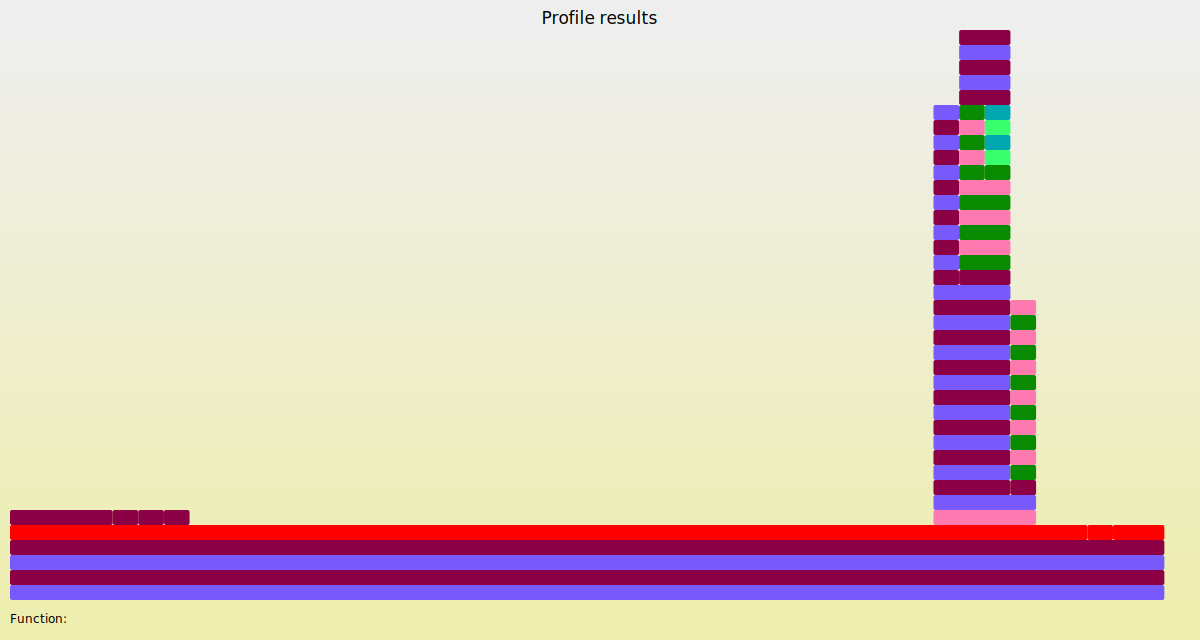

0.063036 seconds (1.01 M allocations: 30.855 MB, 6.85% gc time)


In [8]:
p = Pendulum(1.0, 1.0, 0.1, 9.81)
state = PendulumState{Float64}(0.0, 0.0)
input = PendulumInput{Float64}(0.0)
Profile.clear()
@time @profile for i = 1:1e6
    xd = dynamics(p, 0, state, input)
end
ProfileView.view()

In [9]:
wrapped_dynamics{T}(x::Vector{T}) = dynamics(p, 0, PendulumState{T}(x[1], x[2]), PendulumInput{T}(x[3]))
g = ForwardDiff.jacobian(wrapped_dynamics)

j (generic function with 1 method)

In [11]:
wrapped_double{T}(x::Vector{T}) = dynamics(p, 0, DoublePendulumState())

wrapped_double (generic function with 1 method)

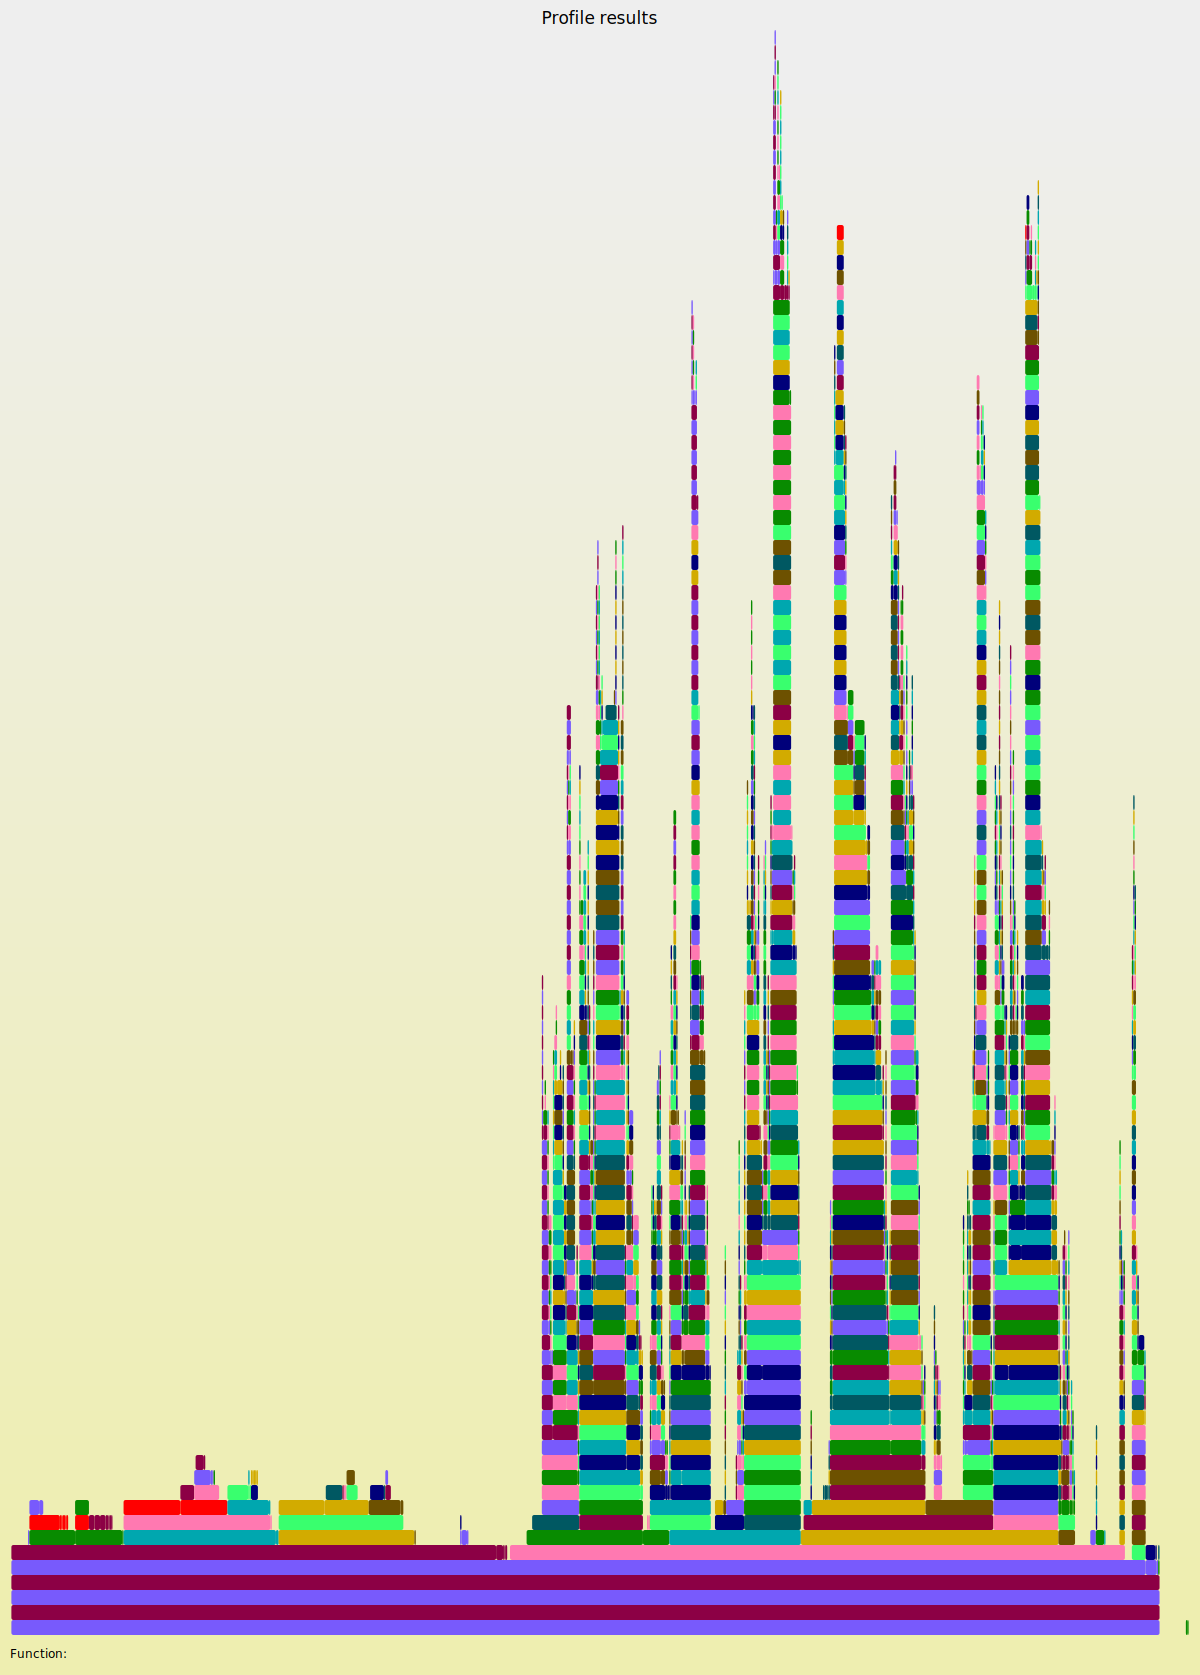

1.179350 seconds (1.97 M allocations: 119.750 MB, 1.96% gc time)


In [12]:
Profile.clear()
@time @profile for i = 1:1e5; g([1.,2.,3.]); end
ProfileView.view()

In [13]:
g([1.,2.,3.])

2x3 Array{Float64,2}:
  0.0      1.0  0.0
 -5.30037  0.0  1.0

In [14]:
dynamics(p, 0, PendulumState{Float64}(1.0, 2.0), PendulumInput(3.))

PendulumState{Float64}(PendulumPosition{Float64}(2.0),PendulumVelocity{Float64}(-5.254830360965466))

In [15]:
@code_warntype(dynamics(p, 0, state, input))

Variables:
  p::Pendulum{Float64}
  t::Int64
  x::PendulumState{Float64}
  u::PendulumInput{Float64}
  thetadd::Float64
  ##xs#7696::Tuple{Float64}

Body:
  begin  # In[6], line 2:
      GenSym(5) = (top(getfield))(p::Pendulum{Float64},:mass)::Float64
      GenSym(4) = (top(getfield))(p::Pendulum{Float64},:gravity)::Float64
      GenSym(3) = (top(getfield))(p::Pendulum{Float64},:length)::Float64
      GenSym(0) = (top(getfield))((top(getfield))(x::PendulumState{Float64},:position)::PendulumPosition{Float64},:theta)::Float64
      GenSym(2) = (top(ccall))((top(tuple))("sin",Base.Math.libm)::Tuple{ASCIIString,ASCIIString},Base.Math.Float64,(top(svec))(Base.Math.Float64)::SimpleVector,GenSym(0),0)::Float64
      thetadd = (Base.box)(Base.Float64,(Base.div_float)((Base.box)(Base.Float64,(Base.sub_float)((top(getfield))(u::PendulumInput{Float64},:theta)::Float64,(Base.box)(Base.Float64,(Base.mul_float)((Base.box)(Base.Float64,(Base.mul_float)((Base.box)(Base.Float64,(Base.mul_float)(GenSym(

In [16]:
state = PendulumState{Float64}(0., 0)

PendulumState{Float64}(PendulumPosition{Float64}(0.0),PendulumVelocity{Float64}(0.0))

In [17]:
destructure([state])

2x1 Array{Float64,2}:
 0.0
 0.0

In [18]:
@which reinterpret(Float64, [state], (2,))

reinterpret{T,S,N}(::Type{T}, a::Array{S,N}, dims::NTuple{N,Int64}) at array.jl:119

In [19]:
state[2][1]

::Float64))))))
  end::PendulumState{Float64}


0.0

In [20]:
immutable PendulumPosition{T} <: FixedVectorNoTuple{1, T}
    theta::T
end

immutable PendulumVelocity{T} <: FixedVectorNoTuple{1, T}
    theta::T
end

immutable PendulumPositionAndVelocity{T} <: FixedVectorNoTuple{2, T}
    position::PendulumPosition{T}
    velocity::PendulumVelocity{T}
end

LoadError: LoadError: invalid redefinition of constant PendulumPosition
while loading In[20], in expression starting on line 1

In [21]:
state2 = PendulumPositionAndVelocity{Float64}(0, 0)

LoadError: LoadError: UndefVarError: PendulumPositionAndVelocity not defined
while loading In[21], in expression starting on line 1

In [22]:
destructure([state2])

LoadError: LoadError: UndefVarError: state2 not defined
while loading In[22], in expression starting on line 1

In [23]:
?Base.box

No documentation found.

`Core.Intrinsics.box` is of type `IntrinsicFunction`:

**Summary:**

```julia
immutable IntrinsicFunction <: Any
```


In [24]:
isbits(Tuple{Float64, Float64}((1.,2.)))

true

In [25]:
state2

LoadError: LoadError: UndefVarError: state2 not defined
while loading In[25], in expression starting on line 1

In [26]:
state2.position[1]

LoadError: LoadError: UndefVarError: state2 not defined
while loading In[26], in expression starting on line 1

In [27]:
state.(1)

PendulumPosition{Float64}(0.0)

In [28]:
s = [state, PendulumState{Float64}(1., 0), PendulumState{Float64}(2., 0) ]

3-element Array{PendulumState{Float64},1}:
 PendulumState(PendulumPosition{Float64}(0.0),PendulumVelocity{Float64}(0.0))
 PendulumState(PendulumPosition{Float64}(1.0),PendulumVelocity{Float64}(0.0))
 PendulumState(PendulumPosition{Float64}(2.0),PendulumVelocity{Float64}(0.0))

In [29]:
destructure(s)

2x3 Array{Float64,2}:
 0.0  1.0  2.0
 0.0  0.0  0.0

In [30]:
v = [Vec(i,-i,1) for i=1:10]

10-element Array{FixedSizeArrays.Vec{3,Int64},1}:
 Vec(1,-1,1)  
 Vec(2,-2,1)  
 Vec(3,-3,1)  
 Vec(4,-4,1)  
 Vec(5,-5,1)  
 Vec(6,-6,1)  
 Vec(7,-7,1)  
 Vec(8,-8,1)  
 Vec(9,-9,1)  
 Vec(10,-10,1)

In [31]:
v[1][1:2]

(1,-1)

In [32]:
destructure(v)[1,1] = 5

5

In [33]:
v

10-element Array{FixedSizeArrays.Vec{3,Int64},1}:
 Vec(5,-1,1)  
 Vec(2,-2,1)  
 Vec(3,-3,1)  
 Vec(4,-4,1)  
 Vec(5,-5,1)  
 Vec(6,-6,1)  
 Vec(7,-7,1)  
 Vec(8,-8,1)  
 Vec(9,-9,1)  
 Vec(10,-10,1)

In [34]:
v[1]._

(5,-1,1)

In [35]:
super(Vec{3, Float64})

FixedSizeArrays.FixedArray{Float64,1,Tuple{3}}